In [1]:
from cellshape_cloud.cloud_autoencoder import CloudAutoEncoder

In [18]:
import torch

# checkpoint = torch.load(
#                 '/run/user/1128299809/gvfs/smb-share:server=rds.icr.ac.uk,share=' \
#     'data/DBI/DUDBI/DYNCESYS/mvries/ResultsAlma/' \
#     'foldingnet_foldingnet_512_pretrained_001/StartFromShapeNet/kzb0fwhm/checkpoints/epoch=241-step=30976.ckpt', 
#     map_location=lambda storage, loc: storage
#             )

checkpoint = torch.load(
                '/home/mvries/Documents/Testing_output_cloud/foldingnet_foldingnet_512_pretrained_001/StartFromShapeNet_local/1hfinbte/checkpoints/last.ckpt', 
    map_location=lambda storage, loc: storage
            )

In [23]:
model = CloudAutoEncoder(
        num_features=512,
        k=16,
        encoder_type='foldingnet',
        decoder_type='foldingnet',
        shape='sphere',
    sphere_path='/home/mvries/Documents/GitHub/cellshape-cloud/cellshape_cloud/vendor/sphere.npy'
    )

In [24]:
from cellshape_cloud.lightning_autoencoder import CloudAutoEncoderPL
import easydict

args = easydict.EasyDict(
    {"learning_rate_autoencoder": 0.0001,
       "encoder_type": "foldnet",
       "decoder_type": "foldingnetbasic",
       "k": 16,
    "dataframe_path": '/mnt/nvme0n1/Datasets/SingleCellFromNathan_17122021/all_data_removedwrong_ori_removedTwo_train_test.csv',
    "cloud_dataset_path": '/mnt/nvme0n1/Datasets/SingleCellFromNathan_17122021/',
    "batch_size": 1,
    "pretrained_path": "/run/user/1128299809/gvfs/smb-share:server=rds.icr.ac.uk,share=data/DBI/DUDBI/DYNCESYS/mvries/Datasets/CellShape/UploadData/cellshapeOutput/Models/cloud_autoencoder/dgcnn_foldinget_50_004_predictions_NEW_09.pt",
#      'pretrained_path': '/run/user/1128299809/gvfs/smb-share:server=rds.icr.ac.uk,share=data/DBI/DUDBI/DYNCESYS/mvries/ResultsAlma/cellshape-cloud/VesselMNIST/dgcnn_foldingnetbasic_128_pretrained_001/lightning_logs/version_11092805/checkpoints/last.ckpt',
    "dataset_type": "Other"})
autoencoder = CloudAutoEncoderPL(args=args, model=model)

In [25]:
autoencoder.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [26]:
from cellshape_cloud.pointcloud_dataset import (
    PointCloudDataset,
    SingleCellDataset,
    GefGapDataset,
    ModelNet40,
    ShapeNetDataset,
    OPMDataset,
    VesselMNIST3D,
)
dataset = SingleCellDataset(
            args.dataframe_path,
            args.cloud_dataset_path,
            num_points=2048,
        )

In [27]:
from torch.utils.data import DataLoader

dataloader = DataLoader(
        dataset, batch_size=1, shuffle=False, num_workers=4
    )

In [28]:
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)
all_feat = []
all_outputs = []
all_inputs = []
labels = []
serial_numbers = []
for data in tqdm(dataloader):
    inputs = data[0]
    lab = data[1]
    ser_num = data[3]
    inputs = inputs.to(device)
    batch_size = inputs.shape[0]

    output, features = autoencoder.model(inputs)
    all_inputs.append(torch.squeeze(inputs).detach().cpu().numpy())
    all_outputs.append(torch.squeeze(output).detach().cpu().numpy())
    all_feat.append(torch.squeeze(features).detach().cpu().numpy())
    labels.append(lab[0])
    serial_numbers.append(ser_num[0])

  1%|▎                                     | 472/65500 [00:02<06:16, 172.55it/s]


KeyboardInterrupt: 

In [29]:
from cellshape_cloud.vendor.chamfer_distance import ChamferLoss

In [30]:
crit = ChamferLoss()
crit(inputs, output)

tensor(145.6138, device='cuda:0', grad_fn=<AddBackward0>)

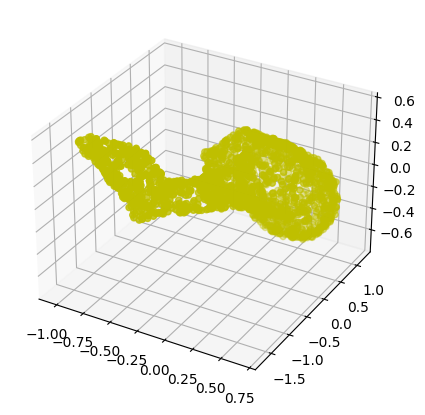

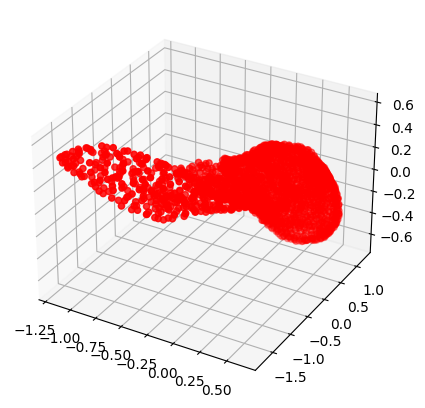

In [31]:
number = 10
points = all_inputs[number]


outs = all_outputs[number]

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(5,5))

ax = plt.axes(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c='y', marker='o', s=20)

# ax[2] = plt.axes(projection='3d')
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter(outs[:,0], outs[:,1], outs[:,2], c='r', marker='o', s=20)